Bacon-Shor code
==============

A simulation of the Bacon-Shor code is carried out based on the work by Egan [1].  The aim work is to validate the noise model for use on the Steane code.  

The Bacon-Shor code with ancilla is set up following the Extended Figure One of Egan's paper.

First we simulate encoding the logical zero and logical one state and find the errors in logical state preparation by evaluating the parities and compared these with Egan's paper.

Next we simulate manufacturing errors in the qubits by applying X or Z Pauli gates to qubits and compare the population of the ancilla qubits with that found by Egan.

To have a good fit with Egan's results we need to double the two gate depolarising errors that we use.  It maybe that these higher errors are more suitable for the Steane code simulation because there is more noise from cross talk for a complex circuit.

This is part of an MSc project on the Steane code.  Please see https://goldsmdn.github.io/ for full details.

[1] Egan L, Debroy DM, Noel C, Risinger A, Zhu D, Biswas D, et al. Fault-Tolerant Operation of a Quantum Error-Correction Code. arXiv Available from: http://arxiv.org/abs/2009.11482

Import the necessary function modules.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import matplotlib.pyplot as plt
import numpy as np

Define constants so the process flow can be controlled from one place:

In [2]:
LOGICAL_ONE = True
Z_LOGICAL = True

BLOCKS = 3
DATA_QUBITS = BLOCKS ** 2
ANCILLAS = 2
ANCILLA_QUBITS = ANCILLAS ** 2

MEASURE_Z = True

#control noise
NOISE = True                             #Test with noise
SHOTS = 10000                            #Number of shots to run    
MEASURE_NOISE = 0.0046                   #Measurement noise not relevant
SINGLE_GATE_DEPOLARISING = 0.000366      #Single gate noise   
#TWO_GATE_DEPOLARISING = 0.0102           #Two gate noise
TWO_GATE_DEPOLARISING = 0.0204
#  note change to agree results - may need to change back

SIMULATOR = Aer.get_backend('qasm_simulator')

Function to initialise circuit

In [3]:
def initialise(data_qubits = DATA_QUBITS, ancilla_qubits = ANCILLA_QUBITS):
    cd = QuantumRegister(data_qubits,'data')    # initialize code bits with nine qubits in the 0 state
    ca = QuantumRegister(ancilla_qubits,'ancilla') # initialize ancilla bits with four qubits in the 0 state

    sd = ClassicalRegister(data_qubits,'measure_data')    # nine measurement bit for the data    
    sa = ClassicalRegister(ancilla_qubits,'measure_ancilla') # four measurement bit for the ancilla   

    qc = QuantumCircuit(cd, ca, sd, sa)
    return cd, ca, sd, sa, qc

Function to set up first non fault tolerant part of encoding circuit

In [4]:
#def encoding_nft(qc, logical_one = LOGICAL_ONE, hadamard = True, blocks = BLOCKS):
def encoding_nft(qc, logical_one = LOGICAL_ONE,  blocks = BLOCKS):
    for count in range(0, blocks * blocks):
        qc.reset(cd[count])
    #Set to logical one if required
    if logical_one:
        qc.x(cd[0])
#   if hadamard:
#       qc.h(cd[0])
    qc.cx(cd[0],cd[blocks])
    qc.cx(cd[0],cd[blocks * 2])
    return

Function to set up second fault tolerant part of encoding circuit noting that the settings for the first three qubits are repeated three times.

In [5]:
def encoding_ft(qc , z_logical = Z_LOGICAL, blocks = BLOCKS):
    for count in range(BLOCKS):
        first_qubit = count * BLOCKS
        second_qubit = count * BLOCKS + 1
        third_qubit = count * BLOCKS + 2
        qc.h(cd[first_qubit])
        qc.cx(cd[first_qubit],cd[second_qubit])
        qc.cx(cd[first_qubit],cd[third_qubit])
        if z_logical:
            #only need post encoding Hadamard for the z_logical gate
            qc.h(cd[first_qubit])
            qc.h(cd[second_qubit])
            qc.h(cd[third_qubit])        
    qc.barrier()
    return

Function to test the ancilla with an X and Z error and check that the correct error syndrome is returned.

In [6]:
def x_testing(qc, test_x_qubit = 0):
    qc.x(test_x_qubit)
    qc.barrier()
    return

In [7]:
def z_testing(qc, test_z_qubit = 0):
    qc.z(test_z_qubit)
    qc.barrier()
    return

Function to set up X Stabilizers

In [8]:
def x_stabilizers(qc, ancillas = ANCILLAS , blocks = BLOCKS ):
    for ancilla in range ( 0 , ancillas):
        # loop over ancillas
        qc.h(ca[ancilla + ancillas])
        #ancilla count starts at ANCILLAS
        for count in range(blocks):
            first_qubit = count * blocks + ancilla
            second_qubit = count * blocks + ancilla + 1
            qc.cx(ca[ancilla + ancillas],cd[first_qubit])
            qc.cx(ca[ancilla + ancillas],cd[second_qubit])
            #ancilla count starts at ANCILLAS
        qc.h(ca[ancilla + ancillas])
        qc.barrier()
    return

Function to set up Z Stabilizers

In [9]:
def z_stabilizers(qc, ancillas = ANCILLAS, blocks = BLOCKS):
    for ancilla in range (0 , ancillas):
        for count in range(blocks):
            first_qubit = count + blocks * ancilla 
            second_qubit = count + blocks * (ancilla + 1)
            qc.cx(cd[first_qubit] , ca[ancilla])
            qc.cx(cd[second_qubit] , ca[ancilla])
        qc.barrier()
    return

Function to populate noise model

In [10]:
def get_noise(p_meas,s_gate,t_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(s_gate, 1)
    error_gate2 = depolarizing_error(t_gate, 1)
    error_gate3 = error_gate2.tensor(error_gate2)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, 'measure') # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ['x', 'y', 'z', 'h', 's', 'sdg'])  # single qubit gate errors
    noise_model.add_all_qubit_quantum_error(error_gate3, ['cx', 'rxx', 'cz']) # two qubit gate error is applied to cx gates

    return noise_model

Function to count measurements  for each possible combinations of ancilla

In [11]:
def find_ancilla_values(counts, ancilla_qubits = ANCILLA_QUBITS):
    #find the possible ancilla in binary
    possible_ancilla_list = []
    for i in range(2 ** (ancilla_qubits)):
        possible_ancilla_value = format(i, '04b')
        possible_ancilla_list.append(possible_ancilla_value)

    #use to initialise dictionary to hold the ancilla values
    ancilla_values = {i:0 for i in possible_ancilla_list}  

    # loop through results and summarise by ancilla
    for key, value in counts.items():
        #split out ancilla part of key
        ancilla = key.split()[0]
        old_count = ancilla_values[ancilla]
        new_count = old_count + value
        ancilla_values[ancilla] = new_count
    return(ancilla_values)

Function to count measurements by individual ancilla

In [12]:
def find_individual_ancilla_values(ancilla_values, data_qubits = DATA_QUBITS, ancilla_qubits = ANCILLA_QUBITS ):
    #initialise dictionary to hold values
    individual_ancilla_values = {str(i): 0 for i in range(data_qubits + 1,data_qubits + 1 + ancilla_qubits ) }

    for ancilla, value in ancilla_values.items():
        for i in range(ancilla_qubits):
            bit = ancilla[i]
            if bit == '1':
                # note that order of qiskit qubit order needs to be reversed to compare with the paper
                key = str(data_qubits + ancilla_qubits - i)
                old_count = individual_ancilla_values[key]
                new_count = old_count + value
                individual_ancilla_values[key] = new_count
    return(individual_ancilla_values)

Execute results and print out.  The format is two bits for the Z error syndrome, two bits for the X error syndrome and seven bits for the Steane data bit. 

In [13]:
def find_parity(counts , data_qubits = DATA_QUBITS):
    #initialise dictionary to hold counts
    parity_count = {str(i) : 0 for i in range(2)}
    for key, value in counts.items():
        #split out data part of key
        data = key.split()[1]
        parity = 0
        for i in range(data_qubits):
            bit = data[i]
            if bit == '1':
                #parity has changed
                if parity == 0:
                    parity = 1
                elif parity == 1:
                    parity = 0
                else:
                    raise Exception("Unexpected error calculating parity")
        old_count = parity_count[str(parity)]
        new_count = old_count + value
        parity_count[str(parity)] = new_count
    return(parity_count)

Run circuit and calculate results for logical_one and logical_zero

In [14]:
#initialise calculation results
values = []
labels = []

for logical_one in [False, True]:
    cd, ca, sd, sa, qc = initialise()
    encoding_nft(qc, logical_one)
    encoding_ft(qc)
    if NOISE:
        noise_model = noise_model = get_noise(MEASURE_NOISE , SINGLE_GATE_DEPOLARISING , TWO_GATE_DEPOLARISING)
    qc.measure(cd , sd)
    qc.measure(ca , sa)

    if NOISE:
        result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
    else:
        result = execute(qc, SIMULATOR, shots=SHOTS).result()

    counts = result.get_counts(qc)
    parity_values = find_parity(counts)
    print('The parity values are ', parity_values, 'with logical one', logical_one)
    
    if logical_one:
        #matching Egan's numbering
        ideal = -1 
        measure = -1 * parity_values.get('1') / SHOTS
        difference = ideal - measure
        values.append(difference) 
        labels.append('|1L>')
    else:
        #logical zero
        ideal = 1
        measure = 1 * parity_values.get('0') / SHOTS
        difference = ideal - measure
        values.append(difference)
        labels.append('|0L>')
        
    print(f'The difference is {difference:.4f} with logical one {logical_one}')

The parity values are  {'0': 8398, '1': 1602} with logical one False
The difference is 0.1602 with logical one False
The parity values are  {'0': 1605, '1': 8395} with logical one True
The difference is -0.1605 with logical one True


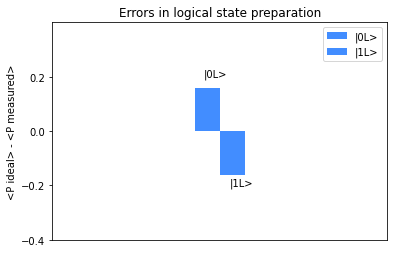

In [15]:
#graph constants
YMIN = -0.4
YMAX = 0.4
YTICK = 0.2
XMIN = -0.2
XMAX = 0.2
SIZE = 20

x = np.arange(len(labels))  # the label locations
width = 0.03  # the width of the bars

fig, ax = plt.subplots()
rects0 = ax.bar(x - width/2, values[0], width, label=labels[0], color = '#428dff')
rects1 = ax.bar(x + width/2, values[1], width, label=labels[1], color = '#428dff')

ax.set_ylabel('<P ideal> - <P measured>')
ax.set_title('Errors in logical state preparation')
ax.legend()

plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

plt.xlim(XMIN, XMAX)
ax.axes.xaxis.set_ticks([])

# print labels on top of or on bottom of bars
for i in range(len(labels)):
    plt.text(x = i * width - 1.25 * width/2, y = 1.25 * values[i], s = labels[i], size = 10)

#ax.bar_label(rects0, padding=3)
#ax.bar_label(rects1, padding=3)

#fig.tight_layout()

fname = "Bacon_Shor_errors_in_logical_state_graph.png"
plt.savefig(fname)

Here are the actual observations from Egan for comparison.  The blue columns fault tolerant sections are comparable.
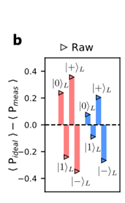

Print out circuit:

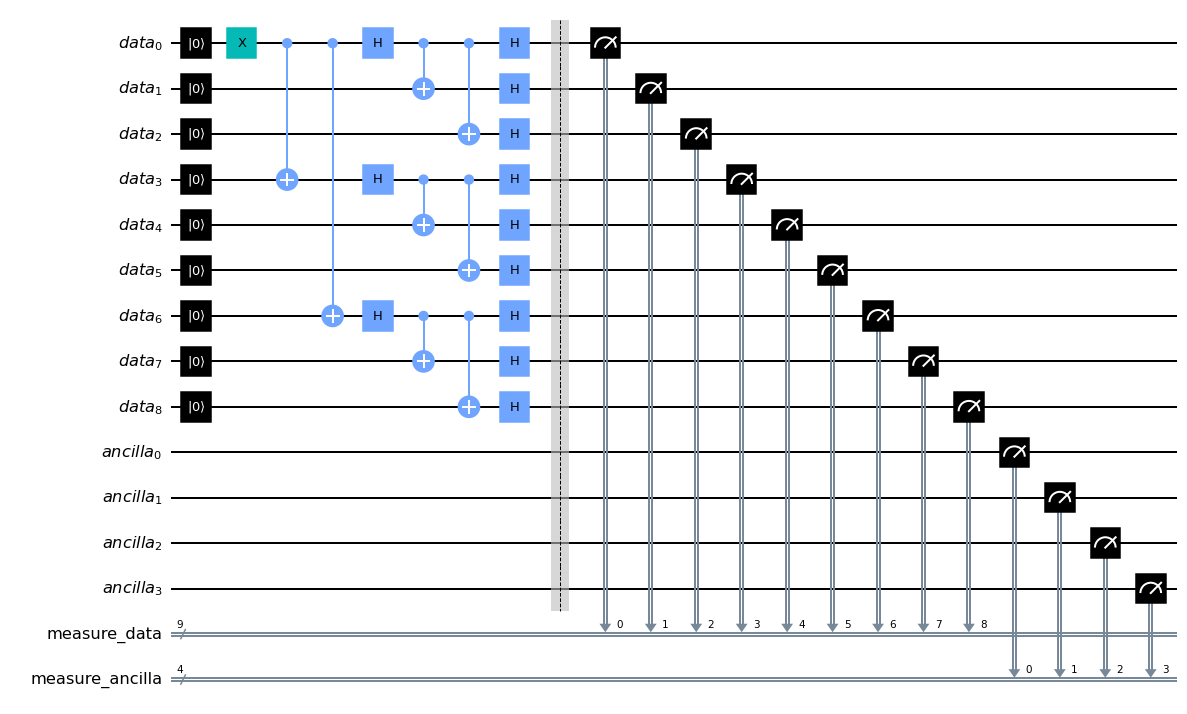

In [16]:
qc.draw(output='mpl', filename = 'Bacon_Shor_encoding_circuit.jpg', fold=60)

Run with different X, Z errors as per Egan paper and find the ancilla populations.

In [17]:
#initialise lists for graphs results
values_list = [[] for i in range(DATA_QUBITS + 1,DATA_QUBITS + 1 + ANCILLA_QUBITS)]
labels_list = [str(i) for i in range(DATA_QUBITS + 1,DATA_QUBITS + 1 + ANCILLA_QUBITS)]
cases_list = []

runs = {'I':{},
        'Z2':{'test_z_qubit': 1},
        'X5':{'test_x_qubit': 4},
        'Y1':{'test_x_qubit': 0,'test_z_qubit': 0},
        'Y5':{'test_x_qubit': 4,'test_z_qubit': 4}
       }
#NB Egan labels the qubits starting at 1 and quiskit uses 0, so need to deduct one from Egan's values.
for cases, parameters in runs.items():
    test_x = True
    if 'test_x_qubit' in parameters:
        x_bit = parameters.get('test_x_qubit')
    else:
        test_x = False
    test_z = True
    if 'test_z_qubit' in parameters:
        z_bit = parameters.get('test_z_qubit')
    else:
        test_z = False
    cd, ca, sd, sa, qc = initialise()
    encoding_nft(qc, logical_one)
    encoding_ft(qc)
    if test_x:
        x_testing(qc, x_bit)
    if test_z:
        z_testing(qc, z_bit)
    x_stabilizers(qc)
    z_stabilizers(qc)
    if NOISE:
        noise_model = noise_model = get_noise(MEASURE_NOISE,SINGLE_GATE_DEPOLARISING,TWO_GATE_DEPOLARISING)
    qc.measure(cd , sd)
    qc.measure(ca , sa)

    if NOISE:
        result = execute(qc, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
    else:
        result = execute(qc, SIMULATOR, shots=SHOTS).result()

    counts = result.get_counts(qc)
    #print ('The different states can be counted.  The simulated result are', counts)
    #print()
    print("For case", cases)
    
    ancilla_values = find_ancilla_values(counts)
    print('The different ancilla values are', ancilla_values)
    print()
    individual_ancilla_values = find_individual_ancilla_values(ancilla_values)
    print('By ancilla the values are ', individual_ancilla_values)
    print()
    
    cases_list.append(cases)
    index = 0
    for labels in labels_list:
        values_list[index].append(individual_ancilla_values.get(labels) / SHOTS)
        index = index + 1

For case I
The different ancilla values are {'0000': 5090, '0001': 850, '0010': 1019, '0011': 557, '0100': 416, '0101': 144, '0110': 146, '0111': 139, '1000': 484, '1001': 161, '1010': 196, '1011': 175, '1100': 229, '1101': 128, '1110': 142, '1111': 124}

By ancilla the values are  {'10': 2278, '11': 2498, '12': 1468, '13': 1639}

For case Z2
The different ancilla values are {'0000': 249, '0001': 112, '0010': 129, '0011': 106, '0100': 469, '0101': 218, '0110': 186, '0111': 167, '1000': 388, '1001': 141, '1010': 139, '1011': 128, '1100': 5107, '1101': 848, '1110': 997, '1111': 616}

By ancilla the values are  {'10': 2336, '11': 2468, '12': 8608, '13': 8364}

For case X5
The different ancilla values are {'0000': 583, '0001': 990, '0010': 860, '0011': 5069, '0100': 130, '0101': 161, '0110': 142, '0111': 421, '1000': 171, '1001': 166, '1010': 178, '1011': 525, '1100': 115, '1101': 127, '1110': 126, '1111': 236}

By ancilla the values are  {'10': 7695, '11': 7557, '12': 1458, '13': 1644}

F

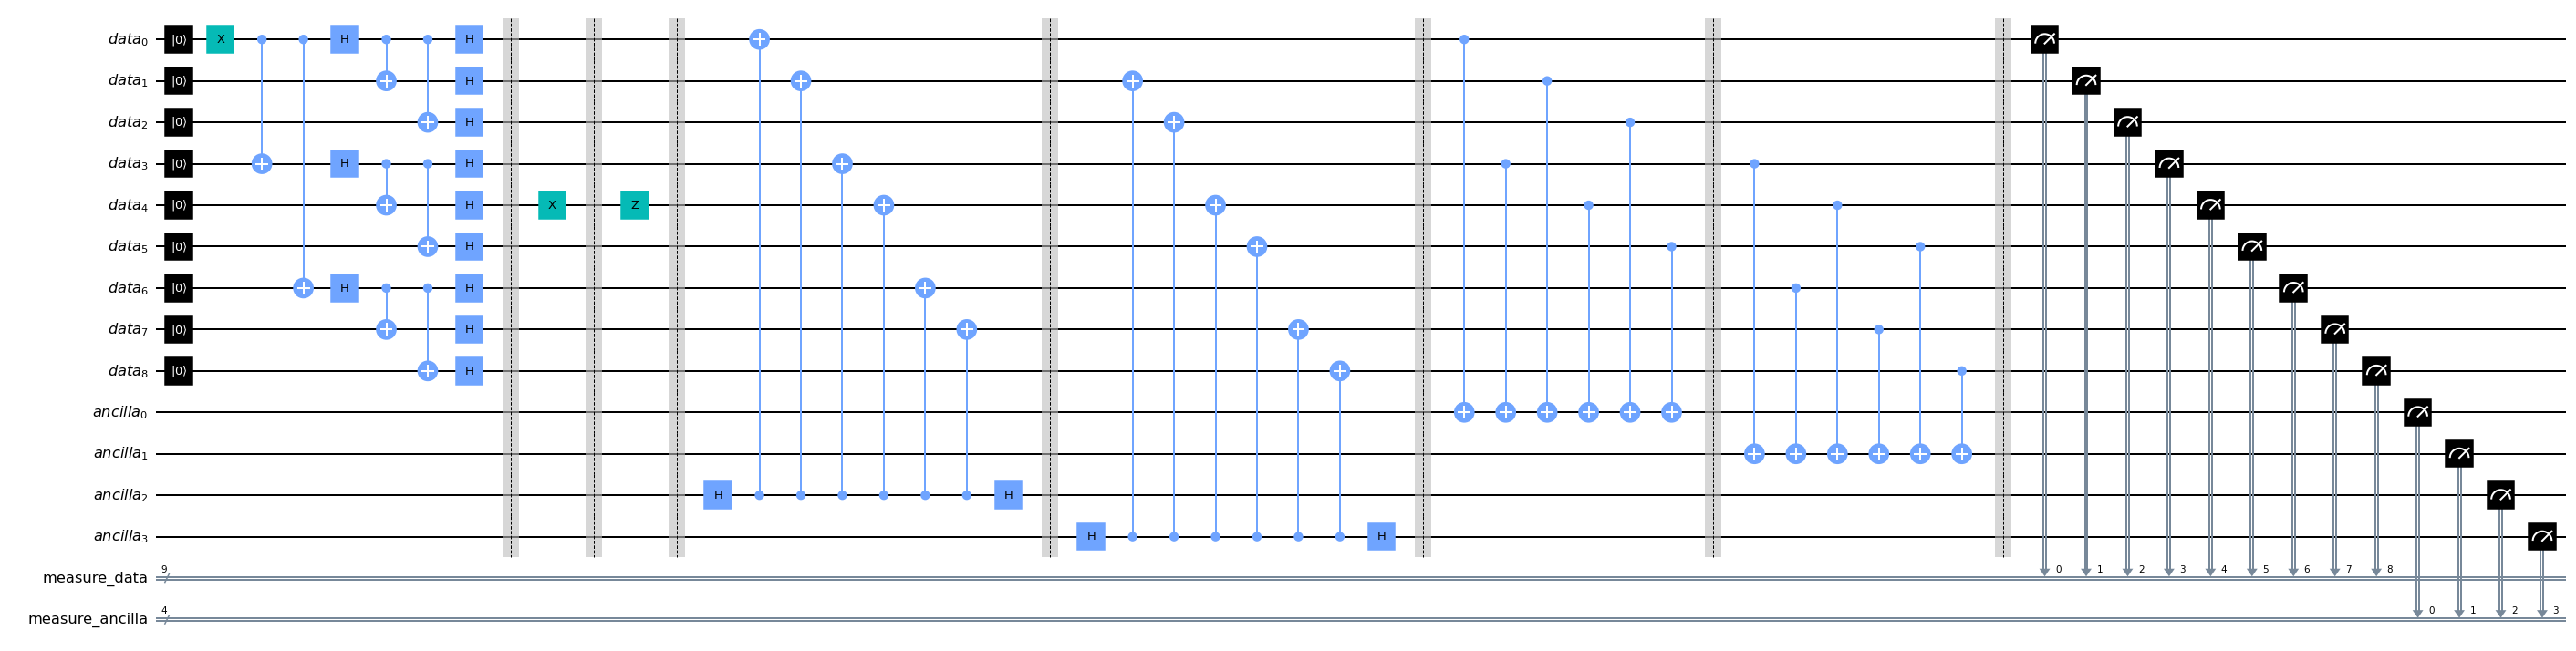

In [18]:
qc.draw(output='mpl', filename = 'Bacon_Shor_full_circuit.jpg', fold=60)

Plot graph of results

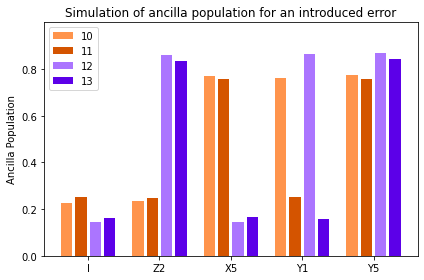

In [19]:
#graph constants
YMIN = 0
YMAX = 1.0
YTICK = 0.2
WIDTH = 0.2
GAP = .8
#XMIN = -0.1
#XMAX = 0.1
#SIZE = 20

x = np.arange(len(cases_list))  # the label locations

fig, ax = plt.subplots()
plt.bar(x - WIDTH * 3 / 2 , values_list[0], color = '#ff944c', width = WIDTH * GAP, label = labels_list[0])
plt.bar(x - WIDTH / 2, values_list[1], color = '#d45400', width = WIDTH * GAP, label = labels_list[1])
plt.bar(x + WIDTH / 2 , values_list[2], color = '#ab75ff', width = WIDTH * GAP, label = labels_list[2])
plt.bar(x + WIDTH * 3 /2, values_list[3], color = '#5c00e8', width = WIDTH * GAP, label = labels_list[3])

ax.set_ylabel('Ancilla Population')
ax.set_title('Simulation of ancilla population for an introduced error')
ax.set_xticks(x)
ax.set_xticklabels(cases_list)
ax.legend()

plt.ylim(YMIN, YMAX)
plt.yticks(np.arange(YMIN, YMAX, YTICK))

fig.tight_layout()

fname = "Bacon_Shor_ancilla_graph.png"
plt.savefig(fname)

Here are the actual observations from Egan for comparison:

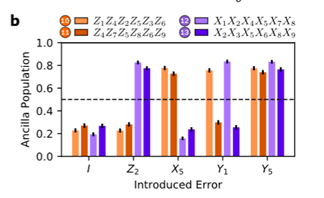